In [1]:
%load_ext autoreload
%autoreload 2

from utils.build_utils import build_retro_iterator, build_forward_iterator, build_model, load_checkpoint
from models.model import ProjectNet
import argparse
import pandas as pd
import numpy as np
import json
import torch
import os
from tqdm import tqdm
from faerun import Faerun
import tmap as tm   
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import manifold
from scipy import stats
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Descriptors3D
from matplotlib.colors import LinearSegmentedColormap
from collections import Counter

## Kmeans clustering

In [26]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def kmeans_clustering(tsne_coords, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    pred_labels = kmeans.fit_predict(tsne_coords)
    return pred_labels

def evaluate_clustering(pred_labels, true_labels):
    ari = metrics.adjusted_rand_score(true_labels, pred_labels)
    nmi = metrics.normalized_mutual_info_score(true_labels, pred_labels)
    return ari, nmi

## USPTO_1k_TPL (test set)

In [ ]:
import json
with open("./data/uspto_1K_TPL_backward/template_supercalss_mapdict.json", "r") as f:
    map_dict = json.load(f)

### HiCLR

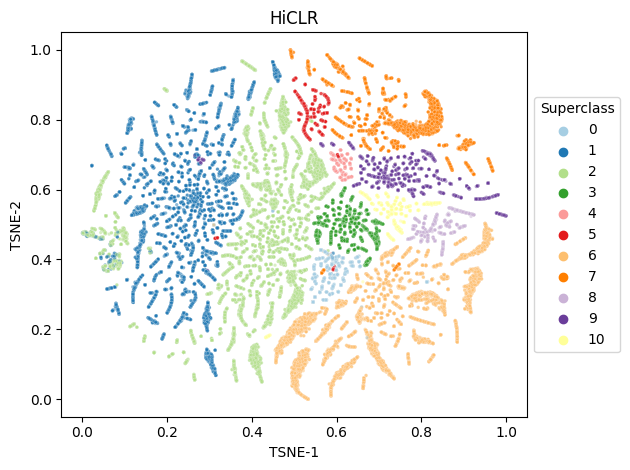

In [ ]:
tsne = pd.read_csv("./result/tsne/uspto_1K_TPL_backward/hiclr_tsne_coord.csv")

fontsize = 10
plt.figure()
sns.scatterplot(x=tsne["x1"], y=tsne["x2"], hue=tsne["superclass"], s=6, palette="Paired", alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=1, fontsize=fontsize, frameon=True, title="Superclass")

# plt.gca().format_coord = lambda x,y: "x={},y={},data={}".format(x,y,tsne.loc[(tsne["x1"]-x).abs().argsort()[0],:])   
# for i in range(100):
#     plt.annotate(tsne.loc[i, 'labels'], (tsne.loc[i,"x1"],tsne.loc[i,"x2"]))

# template = tsne[tsne["labels"]==73]
# for i in template.index:
#     plt.annotate(template.loc[i, 'labels'], (template.loc[i,"x1"],template.loc[i,"x2"]))

plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.title("HiCLR")

plt.tight_layout()
plt.savefig("./figures/tsne/tsne_hiclr.png", dpi=1000)

In [6]:
template_count = Counter(tsne.labels)
most_common = template_count.most_common(10)
most_common_label = [x[0] for x in most_common]
most_common_label

[1, 7, 88, 575, 247, 334, 146, 171, 230, 48]

In [7]:
template_df = tsne[tsne["labels"].isin(most_common_label)]
remains = tsne[~tsne["labels"].isin(most_common_label)]

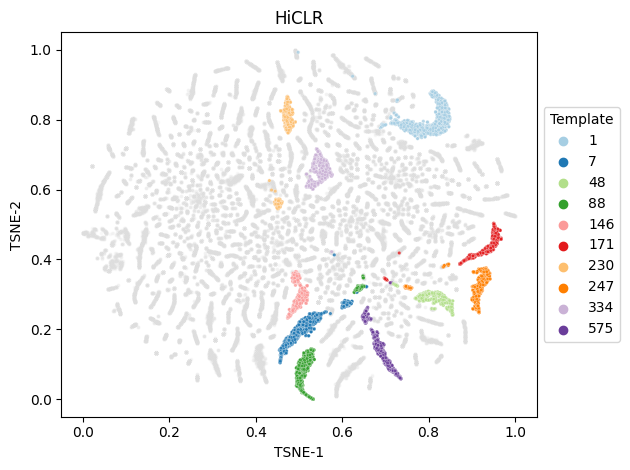

In [8]:
plt.figure()
color_rgb = [(222/256, 222/256, 222/256)]
# sns.scatterplot(x=remains["x1"], y=remains["x2"], s=6, color="#8081807F", alpha=0.5)
sns.scatterplot(x=remains["x1"], y=remains["x2"], s=6, color=color_rgb, alpha=0.2)
sns.scatterplot(x=template_df["x1"], y=template_df["x2"], hue=template_df["labels"], s=6, palette="Paired", alpha=0.8)

plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=1, fontsize=fontsize, frameon=True, title="Template")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.title("HiCLR")
plt.tight_layout()
    
plt.savefig("./figures/tsne/tsne_hiclr_template.png", dpi=1000)
plt.show()

In [28]:
tsne_coords = tsne[["x1", "x2"]].values
true_labels = tsne["superclass"].tolist()
pred_labels = kmeans_clustering(tsne_coords, n_clusters=len(set(true_labels)))
ari, nmi = evaluate_clustering(true_labels, pred_labels)
print("Superclass level: ARI: {:.4f}, NMI: {:.4f}".format(ari, nmi))

true_labels = tsne["labels"].tolist()
pred_labels = kmeans_clustering(tsne_coords, n_clusters=len(set(true_labels)))
ari, nmi = evaluate_clustering(true_labels, pred_labels)
print("Template level: ARI: {:.4f}, NMI: {:.4f}".format(ari, nmi))

Superclass level: ARI: 0.2313, NMI: 0.4918
Template level: ARI: 0.3155, NMI: 0.8999


### HiCLR (w/o Retro)

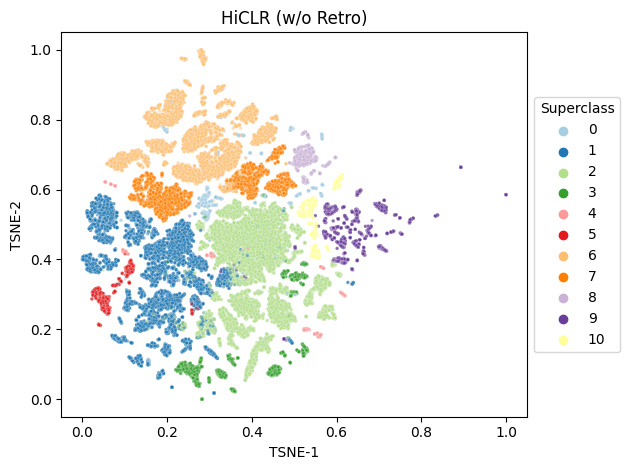

In [12]:
tsne = pd.read_csv("./result/tsne/uspto_1K_TPL_backward/wo_ar_tsne_coord.csv")
tsne["superclass"] = tsne["labels"].apply(lambda x: map_dict[str(x)])

fontsize = 10
plt.figure()
sns.scatterplot(x=tsne["x1"], y=tsne["x2"], hue=tsne["superclass"], s=6, palette="Paired", alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=1, fontsize=fontsize, frameon=True, title="Superclass")

plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.title("HiCLR (w/o Retro)")

plt.tight_layout()
plt.savefig("./figures/tsne/tsne_wo_ar.png", dpi=1000)

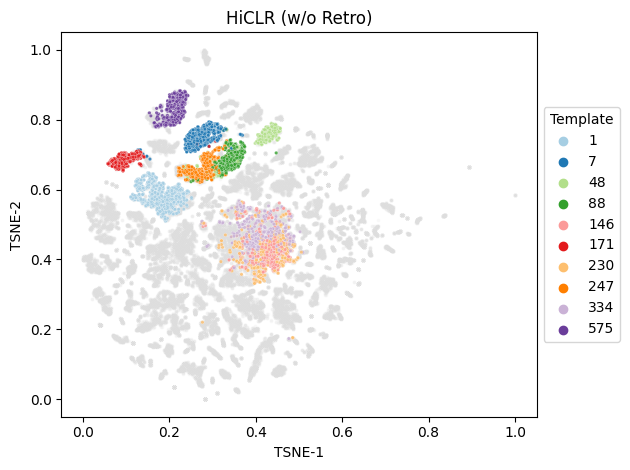

In [13]:
template_df = tsne[tsne["labels"].isin(most_common_label)]
remains = tsne[~tsne["labels"].isin(most_common_label)]
plt.figure()
# plt.scatter(x=tsne["x1"], y=tsne["x2"], color="#B0A8B9", marker=".", s=8, alpha=0.5)
color_rgb = [(222/256, 222/256, 222/256)]
# sns.scatterplot(x=remains["x1"], y=remains["x2"], s=6, color="#8081807F", alpha=0.5)
sns.scatterplot(x=remains["x1"], y=remains["x2"], s=6, color=color_rgb, alpha=0.2)
sns.scatterplot(x=template_df["x1"], y=template_df["x2"], 
                hue=template_df["labels"], s=6, palette="Paired", alpha=0.8)

plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=1, fontsize=fontsize, frameon=True, title="Template")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.title("HiCLR (w/o Retro)")
plt.tight_layout()
    
plt.savefig("./figures/tsne/tsne_wo_ar_template.png", dpi=1000)
plt.show()

In [31]:
tsne_coords = tsne[["x1", "x2"]].values
true_labels = tsne["superclass"].tolist()
pred_labels = kmeans_clustering(tsne_coords, n_clusters=len(set(true_labels)))
ari, nmi = evaluate_clustering(true_labels, pred_labels)
print("Superclass level: ARI: {:.4f}, NMI: {:.4f}".format(ari, nmi))

true_labels = tsne["labels"].tolist()
pred_labels = kmeans_clustering(tsne_coords, n_clusters=len(set(true_labels)))
ari, nmi = evaluate_clustering(true_labels, pred_labels)
print("Template level: ARI: {:.4f}, NMI: {:.4f}".format(ari, nmi))

Superclass level: ARI: 0.3559, NMI: 0.5790
Template level: ARI: 0.1491, NMI: 0.7506


### SupCon-N

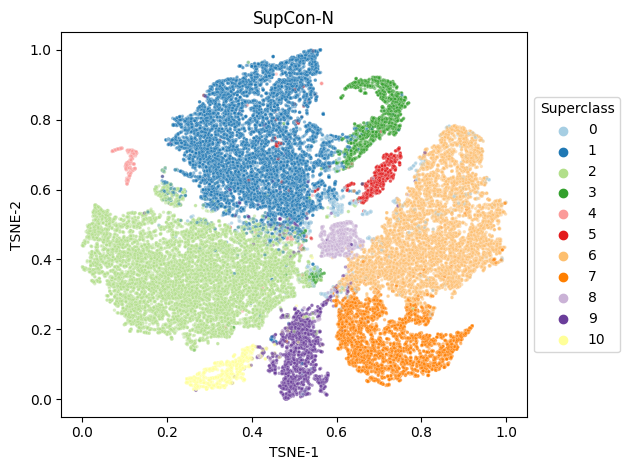

In [18]:
tsne = pd.read_csv("./result/tsne/uspto_1K_TPL_backward/supcon_superclass_tsne_coord.csv")
tsne["superclass"] = tsne["labels"].apply(lambda x: map_dict[str(x)])

plt.figure()
sns.scatterplot(x=tsne["x1"], y=tsne["x2"], hue=tsne["superclass"], s=6, palette="Paired", alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=1, fontsize=fontsize, frameon=True, title="Superclass")

plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.title("SupCon-N")

plt.tight_layout()

plt.savefig("./figures/tsne/tsne_supcon_namerxn.png", dpi=1000)
plt.show()

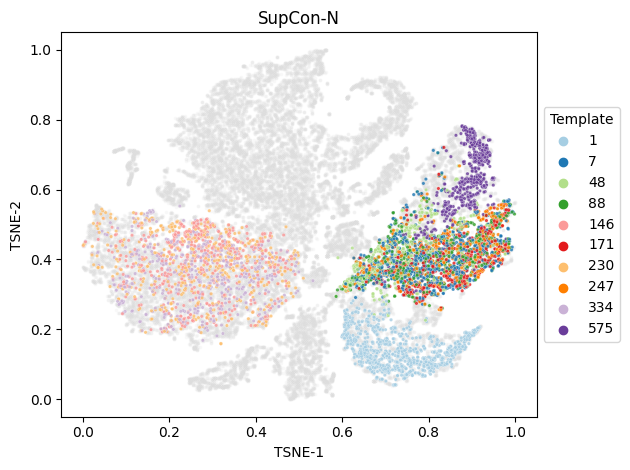

In [ ]:
template_df = tsne[tsne["labels"].isin(most_common_label)]
remains = tsne[~tsne["labels"].isin(most_common_label)]
plt.figure()
color_rgb = [(222/256, 222/256, 222/256)]
# sns.scatterplot(x=remains["x1"], y=remains["x2"], s=6, color="#8081807F", alpha=0.5)
sns.scatterplot(x=remains["x1"], y=remains["x2"], s=6, color=color_rgb, alpha=0.2)
sns.scatterplot(x=template_df["x1"], y=template_df["x2"], hue=template_df["labels"], s=6, palette="Paired", alpha=0.8)

plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=1, fontsize=fontsize, frameon=True, title="Template")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.title("SupCon-N")
plt.tight_layout()
    
# plt.savefig("./figures/tsne/tsne_supcon_namerxn_template.png", dpi=1000)
plt.show()

In [34]:
tsne_coords = tsne[["x1", "x2"]].values
true_labels = tsne["superclass"].tolist()
pred_labels = kmeans_clustering(tsne_coords, n_clusters=len(set(true_labels)))
ari, nmi = evaluate_clustering(true_labels, pred_labels)
print("Superclass level: ARI: {:.4f}, NMI: {:.4f}".format(ari, nmi))

true_labels = tsne["labels"].tolist()
pred_labels = kmeans_clustering(tsne_coords, n_clusters=len(set(true_labels)))
ari, nmi = evaluate_clustering(true_labels, pred_labels)
print("Template level: ARI: {:.4f}, NMI: {:.4f}".format(ari, nmi))

Superclass level: ARI: 0.4086, NMI: 0.6273
Template level: ARI: 0.0356, NMI: 0.5424


### SupCon-T

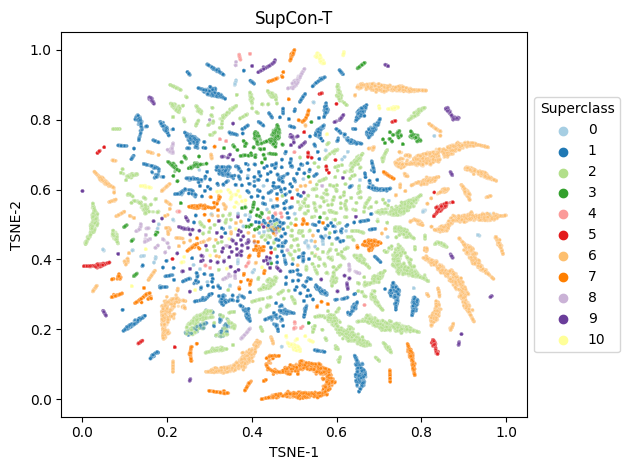

In [19]:
tsne = pd.read_csv("./result/tsne/uspto_1K_TPL_backward/supcon_template_tsne_coord.csv")
tsne["superclass"] = tsne["labels"].apply(lambda x: map_dict[str(x)])
plt.figure()
sns.scatterplot(x=tsne["x1"], y=tsne["x2"], hue=tsne["superclass"], s=6, palette="Paired", alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=1, fontsize=fontsize, frameon=True, title="Superclass")

plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.title("SupCon-T")

plt.tight_layout()

plt.savefig("./figures/tsne/tsne_supcon_template.png", dpi=1000)
plt.show()

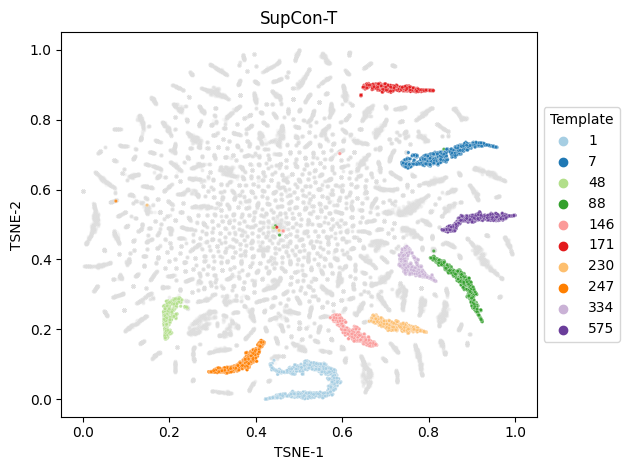

In [ ]:
template_df = tsne[tsne["labels"].isin(most_common_label)]
remains = tsne[~tsne["labels"].isin(most_common_label)]
plt.figure()
color_rgb = [(222/256, 222/256, 222/256)]
# sns.scatterplot(x=remains["x1"], y=remains["x2"], s=6, color="#8081807F", alpha=0.5)
sns.scatterplot(x=remains["x1"], y=remains["x2"], s=6, color=color_rgb, alpha=0.2)
sns.scatterplot(x=template_df["x1"], y=template_df["x2"], hue=template_df["labels"], s=6, palette="Paired", alpha=0.8)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=1, fontsize=fontsize, frameon=True, title="Template")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.title("SupCon-T")
plt.tight_layout()
    
# plt.savefig("./figures/tsne/tsne_supcon_template_template.png", dpi=1000)
plt.show()

In [37]:
tsne_coords = tsne[["x1", "x2"]].values
true_labels = tsne["superclass"].tolist()
pred_labels = kmeans_clustering(tsne_coords, n_clusters=len(set(true_labels)))
ari, nmi = evaluate_clustering(true_labels, pred_labels)
print("Superclass level: ARI: {:.4f}, NMI: {:.4f}".format(ari, nmi))

true_labels = tsne["labels"].tolist()
pred_labels = kmeans_clustering(tsne_coords, n_clusters=len(set(true_labels)))
ari, nmi = evaluate_clustering(true_labels, pred_labels)
print("Template level: ARI: {:.4f}, NMI: {:.4f}".format(ari, nmi))

Superclass level: ARI: 0.0776, NMI: 0.1516
Template level: ARI: 0.3382, NMI: 0.9140


### SelfCon

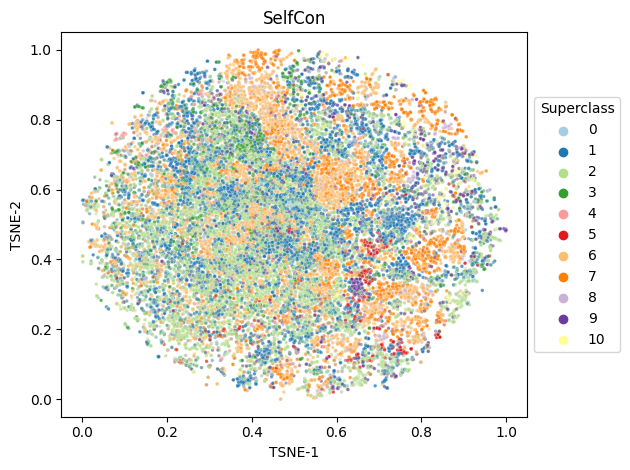

In [16]:
tsne = pd.read_csv("./result/tsne/uspto_1K_TPL_backward/selfsup_tsne_coord.csv")
tsne["superclass"] = tsne["labels"].apply(lambda x: map_dict[str(x)])
plt.figure()
sns.scatterplot(x=tsne["x1"], y=tsne["x2"], hue=tsne["superclass"], s=6, palette="Paired", alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=1, fontsize=fontsize, frameon=True, title="Superclass")

plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.title("SelfCon")

plt.tight_layout()

plt.savefig("./figures/tsne/tsne_selfsup.png", dpi=1000)
plt.show()

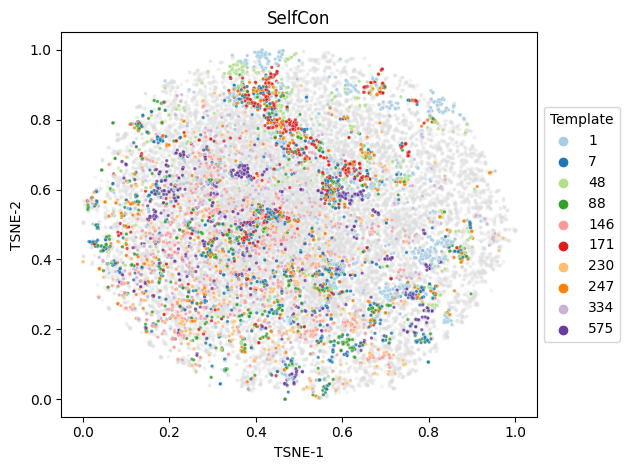

In [17]:
template_df = tsne[tsne["labels"].isin(most_common_label)]
remains = tsne[~tsne["labels"].isin(most_common_label)]
plt.figure()
# plt.scatter(x=tsne["x1"], y=tsne["x2"], color="#B0A8B9", marker=".", s=8, alpha=0.5)
color_rgb = [(222/256, 222/256, 222/256)]
# sns.scatterplot(x=remains["x1"], y=remains["x2"], s=6, color="#8081807F", alpha=0.5)
sns.scatterplot(x=remains["x1"], y=remains["x2"], s=6, color=color_rgb, alpha=0.2)
sns.scatterplot(x=template_df["x1"], y=template_df["x2"], 
                hue=template_df["labels"], s=6, palette="Paired", alpha=0.8)

plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=1, fontsize=fontsize, frameon=True, title="Template")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.title("SelfCon")
plt.tight_layout()
    
plt.savefig("./figures/tsne/tsne_selfsup_template.png", dpi=1000)
plt.show()

In [40]:
tsne_coords = tsne[["x1", "x2"]].values
true_labels = tsne["superclass"].tolist()
pred_labels = kmeans_clustering(tsne_coords, n_clusters=len(set(true_labels)))
ari, nmi = evaluate_clustering(true_labels, pred_labels)
print("Superclass level: ARI: {:.4f}, NMI: {:.4f}".format(ari, nmi))

true_labels = tsne["labels"].tolist()
pred_labels = kmeans_clustering(tsne_coords, n_clusters=len(set(true_labels)))
ari, nmi = evaluate_clustering(true_labels, pred_labels)
print("Template level: ARI: {:.4f}, NMI: {:.4f}".format(ari, nmi))

Superclass level: ARI: 0.0198, NMI: 0.0490
Template level: ARI: 0.0193, NMI: 0.4834


## uspto_50k_typed (retrosynthesis)

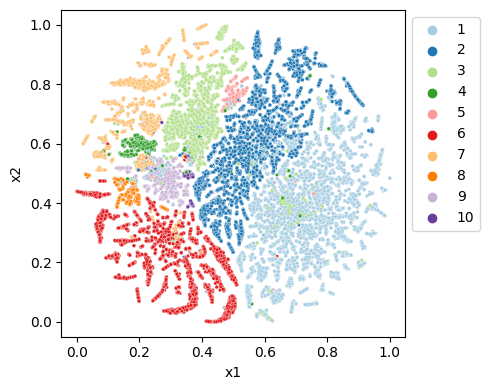

In [28]:
# visualize uspto50k
tsne = pd.read_csv("./result/tsne/50k_tsne_coord.csv")
plt.figure(figsize=(5,4))
sns.scatterplot(x=tsne["x1"], y=tsne["x2"], hue=tsne["labels"], s=6, palette="Paired")
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, fontsize=10)
plt.tight_layout()
# plt.savefig("./figures/50k_tsne.png", dpi=400)
plt.show()

## schneider50k (rxnfp)

In [21]:
tsne["rxn_superclass"].value_counts()

1     14000
6      8000
2      8000
3      5000
10     5000
7      4000
8      3000
9      2000
5      1000
Name: rxn_superclass, dtype: int64

In [36]:
tsne[tsne["rxn_superclass"]==6]["rxn_category"].value_counts()

6.1    3000
6.2    3000
6.3    2000
Name: rxn_category, dtype: int64

In [37]:
tsne[tsne["rxn_category"]==6.1]["rxn_class"].value_counts()

6.1.5    1000
6.1.1    1000
6.1.3    1000
Name: rxn_class, dtype: int64

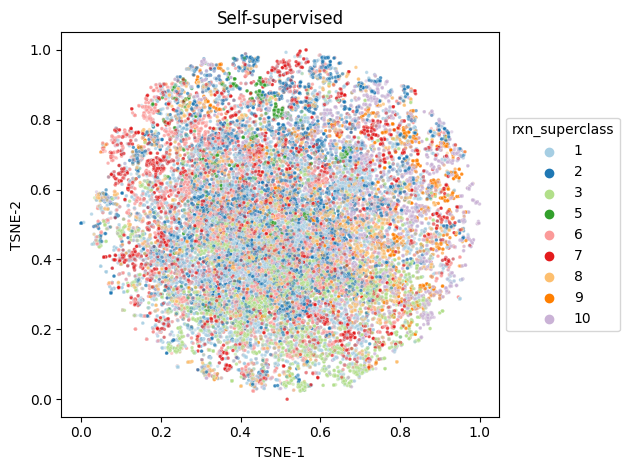

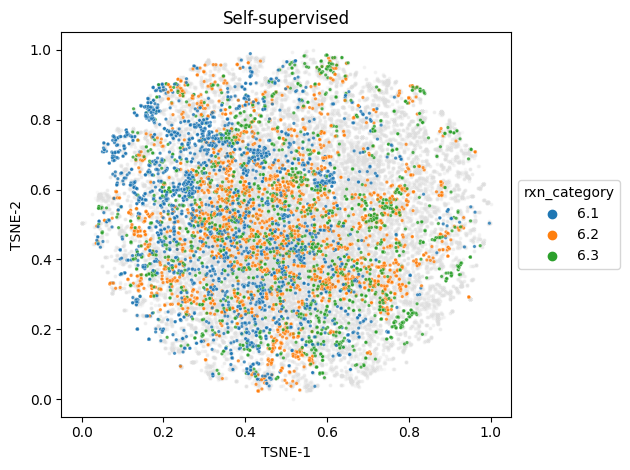

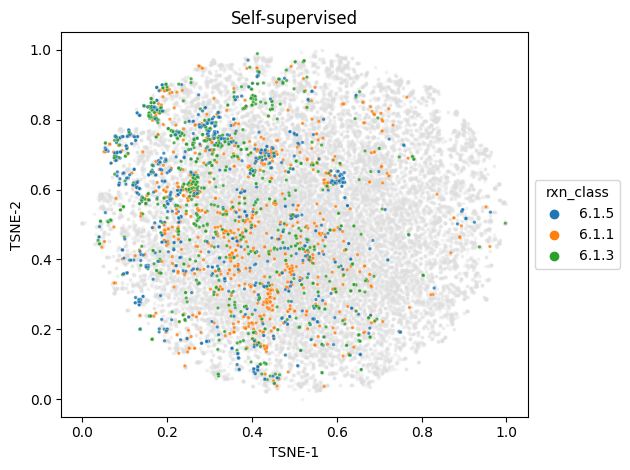

In [45]:
model = "selfsup"
label_cols = ["rxn_superclass", "rxn_category", "rxn_class"]
tsne = pd.read_csv(f"data/rxnfp/tsne/{model}_tsne_coord.csv")
fontsize = 10

#! superclass: color all reactions
#! category: select one superclass
#! class: select one cagetory

for label in label_cols:
    plt.figure()
    
    if label == "rxn_superclass":
        sns.scatterplot(x=tsne["x1"], y=tsne["x2"], hue=tsne[label], s=6, palette="Paired", alpha=0.5)
    else:
        if label == "rxn_category":
            template_df = tsne[tsne["rxn_superclass"].isin([6])]
            remains = tsne[~tsne["rxn_superclass"].isin([6])]
        else:
            template_df = tsne[tsne["rxn_category"].isin([6.1])]
            remains = tsne[~tsne["rxn_category"].isin([6.1])]
        color_rgb = [(222/256, 222/256, 222/256)]
        sns.scatterplot(x=remains["x1"], y=remains["x2"], s=6, color=color_rgb, alpha=0.2)
        sns.scatterplot(x=template_df["x1"], y=template_df["x2"], hue=template_df[label], s=6, palette="tab10", alpha=0.8)

    plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=1, fontsize=fontsize, frameon=True, title=label)
    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.title("Self-supervised")

    plt.tight_layout()

    plt.savefig(f"data/rxnfp/tsne/{model}_{label}_fig.png", dpi=300)
    plt.show()

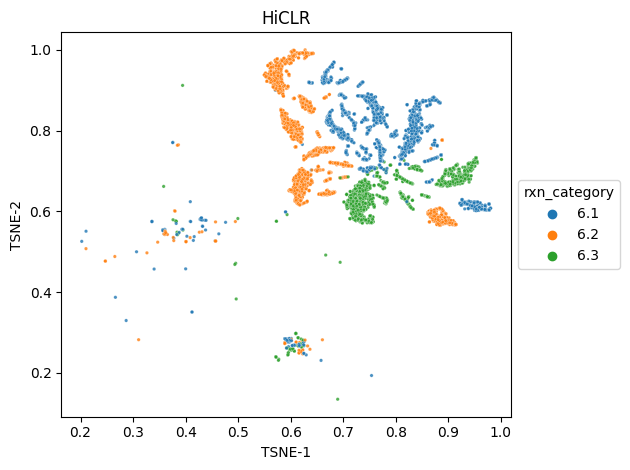

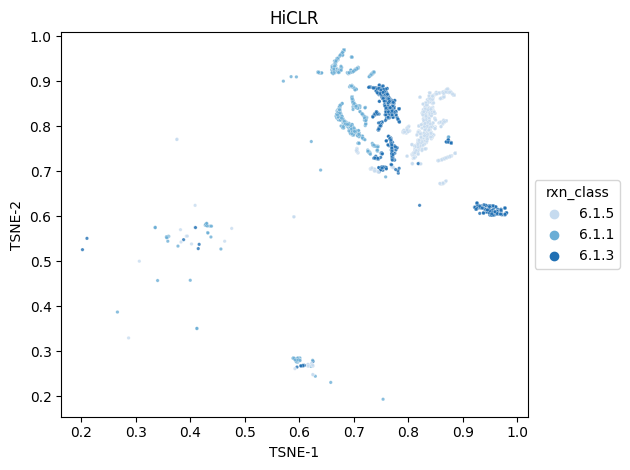

In [52]:
model = "supcon_hierar"
label_cols = ["rxn_category", "rxn_class"]
tsne = pd.read_csv(f"data/rxnfp/tsne/{model}_tsne_coord.csv")
fontsize = 10

for label in label_cols:
    plt.figure()
    
    if label == "rxn_superclass":
        sns.scatterplot(x=tsne["x1"], y=tsne["x2"], hue=tsne[label], s=6, palette="Paired", alpha=0.5)
    else:
        if label == "rxn_category":
            template_df = tsne[tsne["rxn_superclass"].isin([6])]
            remains = tsne[~tsne["rxn_superclass"].isin([6])]
            sns.scatterplot(x=template_df["x1"], y=template_df["x2"], hue=template_df[label], s=6, palette="tab10", alpha=0.8)
        else:
            template_df = tsne[tsne["rxn_category"].isin([6.1])]
            remains = tsne[~tsne["rxn_category"].isin([6.1])]
            sns.scatterplot(x=template_df["x1"], y=template_df["x2"], hue=template_df[label], s=6, palette="Blues", alpha=0.8)

    plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=1, fontsize=fontsize, frameon=True, title=label)

    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.title("HiCLR")

    plt.tight_layout()

    plt.savefig(f"data/rxnfp/tsne/{model}_{label}_wo_bg_fig.png", dpi=300)
    plt.show()

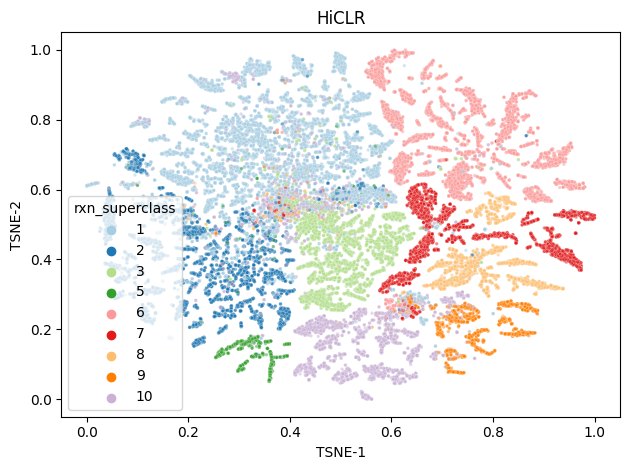

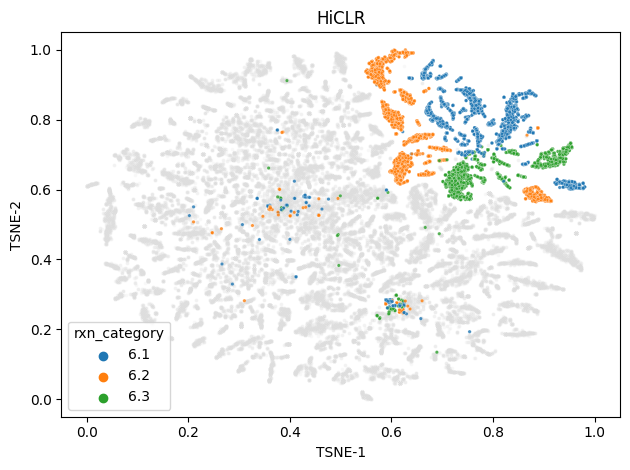

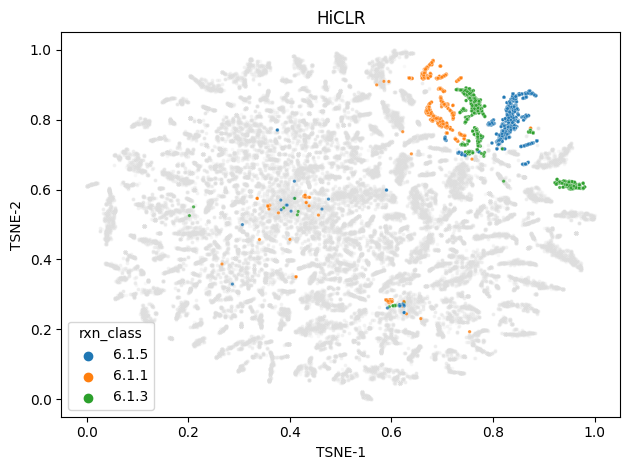

In [54]:
model = "supcon_hierar"
label_cols = ["rxn_superclass", "rxn_category", "rxn_class"]
tsne = pd.read_csv(f"data/rxnfp/tsne/{model}_tsne_coord.csv")
fontsize = 10

for label in label_cols:
    plt.figure()
    
    if label == "rxn_superclass":
        sns.scatterplot(x=tsne["x1"], y=tsne["x2"], hue=tsne[label], s=6, palette="Paired", alpha=0.5)
    else:
        if label == "rxn_category":
            template_df = tsne[tsne["rxn_superclass"].isin([6])]
            remains = tsne[~tsne["rxn_superclass"].isin([6])]
        else:
            template_df = tsne[tsne["rxn_category"].isin([6.1])]
            remains = tsne[~tsne["rxn_category"].isin([6.1])]
        color_rgb = [(222/256, 222/256, 222/256)]
        sns.scatterplot(x=remains["x1"], y=remains["x2"], s=6, color=color_rgb, alpha=0.2)
        sns.scatterplot(x=template_df["x1"], y=template_df["x2"], hue=template_df[label], s=6, palette="tab10", alpha=0.8)

    # plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=1, fontsize=fontsize, frameon=True, title=label)
    plt.legend(fontsize=fontsize, frameon=True, title=label)

    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.title("HiCLR")

    plt.tight_layout()

    plt.savefig(f"data/rxnfp/tsne/{model}_{label}_fig.png", dpi=300)
    plt.show()

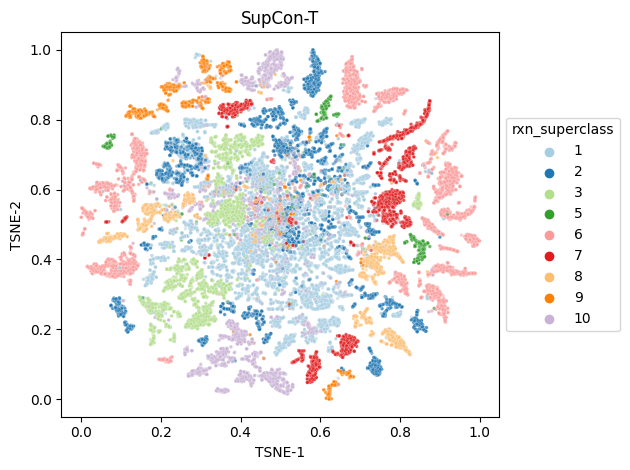

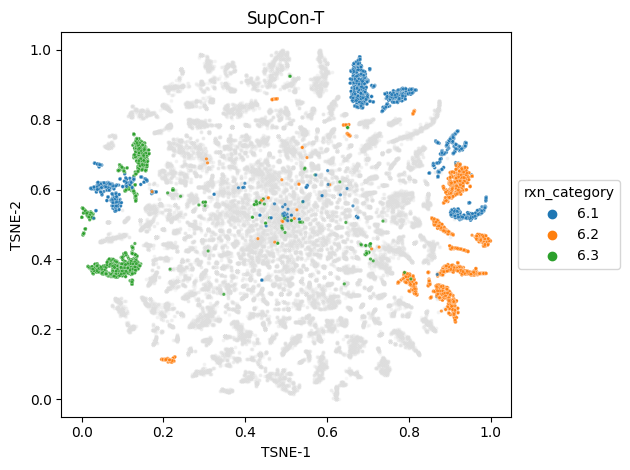

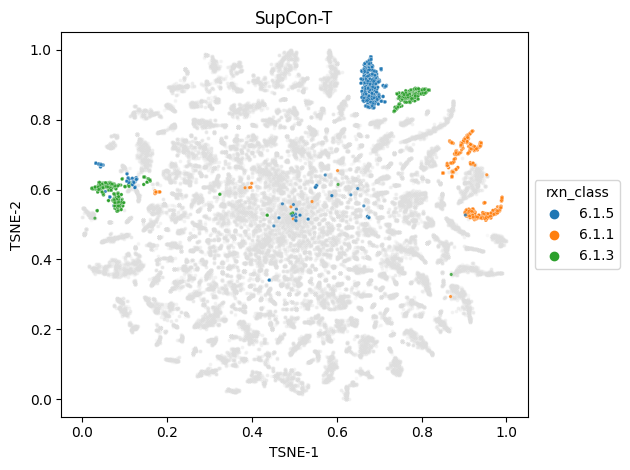

In [48]:
model = "supcon_template"
label_cols = ["rxn_superclass", "rxn_category", "rxn_class"]
tsne = pd.read_csv(f"data/rxnfp/tsne/{model}_tsne_coord.csv")
fontsize = 10

for label in label_cols:
    plt.figure()
    
    if label == "rxn_superclass":
        sns.scatterplot(x=tsne["x1"], y=tsne["x2"], hue=tsne[label], s=6, palette="Paired", alpha=0.5)
    else:
        if label == "rxn_category":
            template_df = tsne[tsne["rxn_superclass"].isin([6])]
            remains = tsne[~tsne["rxn_superclass"].isin([6])]
        else:
            template_df = tsne[tsne["rxn_category"].isin([6.1])]
            remains = tsne[~tsne["rxn_category"].isin([6.1])]
        color_rgb = [(222/256, 222/256, 222/256)]
        sns.scatterplot(x=remains["x1"], y=remains["x2"], s=6, color=color_rgb, alpha=0.2)
        sns.scatterplot(x=template_df["x1"], y=template_df["x2"], hue=template_df[label], s=6, palette="tab10", alpha=0.8)

    plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=1, fontsize=fontsize, frameon=True, title=label)

    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.title("SupCon-T")

    plt.tight_layout()

    plt.savefig(f"data/rxnfp/tsne/{model}_{label}_fig.png", dpi=300)
    plt.show()

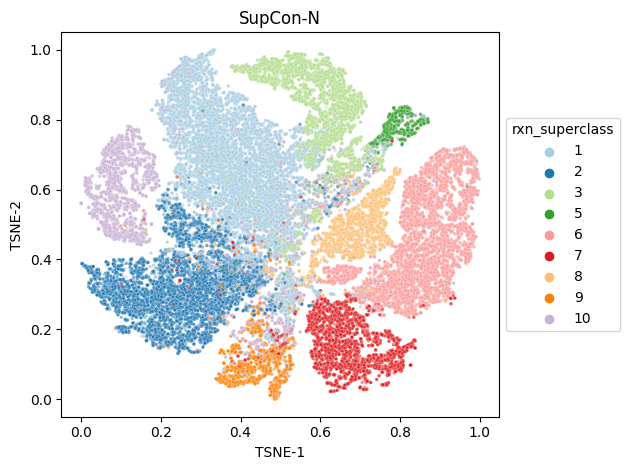

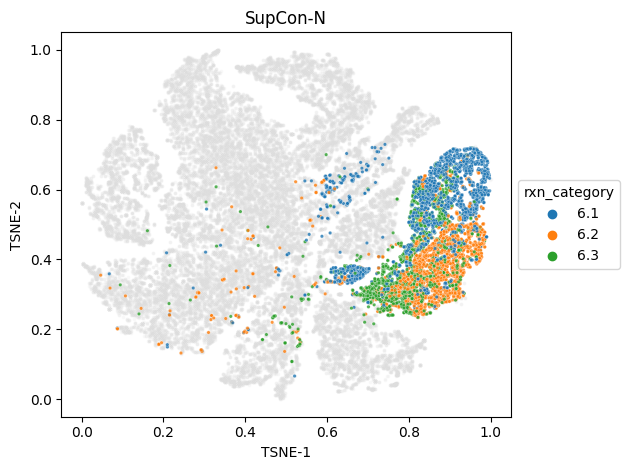

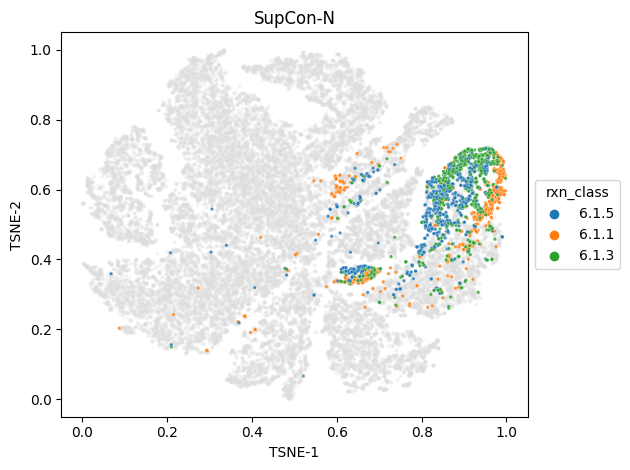

In [49]:
model = "supcon_namerxn"
label_cols = ["rxn_superclass", "rxn_category", "rxn_class"]
tsne = pd.read_csv(f"data/rxnfp/tsne/{model}_tsne_coord.csv")
fontsize = 10

for label in label_cols:
    plt.figure()
    
    if label == "rxn_superclass":
        sns.scatterplot(x=tsne["x1"], y=tsne["x2"], hue=tsne[label], s=6, palette="Paired", alpha=0.5)
    else:
        if label == "rxn_category":
            template_df = tsne[tsne["rxn_superclass"].isin([6])]
            remains = tsne[~tsne["rxn_superclass"].isin([6])]
        else:
            template_df = tsne[tsne["rxn_category"].isin([6.1])]
            remains = tsne[~tsne["rxn_category"].isin([6.1])]
        color_rgb = [(222/256, 222/256, 222/256)]
        sns.scatterplot(x=remains["x1"], y=remains["x2"], s=6, color=color_rgb, alpha=0.2)
        sns.scatterplot(x=template_df["x1"], y=template_df["x2"], hue=template_df[label], s=6, palette="tab10", alpha=0.8)

    plt.legend(loc='center left', bbox_to_anchor=(1,0.5), ncol=1, fontsize=fontsize, frameon=True, title=label)

    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.title("SupCon-N")

    plt.tight_layout()

    plt.savefig(f"data/rxnfp/tsne/{model}_{label}_fig.png", dpi=300)
    plt.show()